# Train NN Model

In [3]:
! module load cuda/11.8.0

'module' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import numpy as np
import pandas as pd
import os
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNet, NeuralNetRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
import gc
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.base import BaseEstimator, TransformerMixin
from skorch.callbacks import EarlyStopping, LRScheduler
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import joblib
from skorch.callbacks import Callback
import time
#from helpful_functions import InputLogTransformer, OutputLogTransformer, build_neural_network, make_datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# import pynvml
# pynvml.nvmlInit()
# handle = pynvml.nvmlDeviceGetHandleByIndex(0)

2.8.0+cpu


## Useful Functions and Classes
- Helps with utilizing `skorch` wrapper for `pytorch` effectively

In [5]:
def log_transform(X): # transforms first column of data.  Alternativly, this could be implemented via operations on DataFrames
    X1 = X.copy()
    X1[:, 0] = np.log(X1[:, 0])
    return X1
def log_inverse(X):
    X1 = X.copy()
    X1[:, 0] = np.exp(X1[:,0])
    return X1

class OutputLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._estimator = StandardScaler()
    def fit(self, y):
        y_copy = y.copy()
        y_copy = np.log(y_copy)
        self._estimator.fit(y_copy)
        
        return self
    def transform(self, y):
        y_copy = y.copy()
        y_copy = np.log(y_copy)
        return self._estimator.transform(y_copy)
    def inverse_transform(self, y):
        y_copy = y.copy()
        y_reverse = np.exp(self._estimator.inverse_transform(y_copy))
        
        return y_reverse

class InputLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._estimator = StandardScaler()
    def fit(self, X):
        X_copy = X.copy()
        X_copy = log_transform(X_copy)
        self._estimator.fit(X_copy)
        
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy = log_transform(X_copy)
        return self._estimator.transform(X_copy)
    def inverse_transform(self, X):
        X_copy = X.copy()
        X_reverse = log_inverse(self._estimator.inverse_transform(X_copy))
        
        return X_reverse
    
class LDIAModel(nn.Module):
    '''
    Perceptron Model of variable architecture for hyperparameter tuning
    '''
    def __init__(self, n_hidden = 1,n_neurons=64,activation=nn.LeakyReLU()):
        super().__init__()
        self.norms = []
        self.layers = []
        self.acts = []
        self.norm0 = nn.BatchNorm1d(3)
        self.layer0 = nn.Linear(3,n_neurons)
        for i in range(1,n_hidden+1):
            self.norms.append(nn.BatchNorm1d(n_neurons))
            self.acts.append(activation)
            self.add_module(f"norm{i}", self.norms[-1])
            self.add_module(f"act{i}", self.acts[-1])
            if (i != n_hidden):
                self.layers.append(nn.Linear(n_neurons, n_neurons))
                self.add_module(f"layer{i}", self.layers[-1])
        self.output = nn.Linear(n_neurons, 3)

    def forward(self, x):
        '''
          Forward pass
        '''
        x = self.layer0(self.norm0(x))
        for norm, layer, act in zip(self.norms, self.layers, self.acts):
            x = act(layer(norm(x)))
        return self.output(x)
    
class DoubleNeuralNetRegressor(NeuralNetRegressor):
    def initialize_module(self):
        super().initialize_module()
        self.module_.double()  # Convert the model's parameters to double precision
        return self

    
def build_neural_network(max_epochs=100, n_hidden=3, n_neurons=32, activation=nn.LeakyReLU(), device=torch.device('cuda'),loss_fn=nn.MSELoss(), optimizer=optim.Adam, lr=1e-2, shuffled=True, batch_size=1024, patience=5, gamma=0.95,valid_ds=None,compiled=False, dtype=np.float32):
    if dtype == np.float64:
        return DoubleNeuralNetRegressor(
        module=LDIAModel,
        max_epochs = max_epochs,
        module__n_hidden=n_hidden,
        module__n_neurons = n_neurons,
        module__activation=activation,
        device=device,
        criterion = loss_fn,
        optimizer=optimizer,
        optimizer__lr = lr,
        iterator_train__shuffle=shuffled,
        batch_size=batch_size,
        callbacks=[('early_stopping', EarlyStopping(patience=patience,monitor='valid_loss')),
        ('lr_scheduler', LRScheduler(policy='ExponentialLR',gamma=gamma))],
        train_split=predefined_split(valid_ds),
        compile = compiled
        )
    else:
        return NeuralNetRegressor(
        module=LDIAModel,
        max_epochs = max_epochs,
        module__n_hidden=n_hidden,
        module__n_neurons = n_neurons,
        module__activation=activation,
        device=device,
        criterion = loss_fn,
        optimizer=optimizer,
        optimizer__lr = lr,
        iterator_train__shuffle=shuffled,
        batch_size=batch_size,
        callbacks=[('early_stopping', EarlyStopping(patience=patience,monitor='valid_loss')),
        ('lr_scheduler', LRScheduler(policy='ExponentialLR',gamma=gamma))],
        train_split=predefined_split(valid_ds),
        compile = compiled
        )

def make_datasets(X, y, *, train_size=0.8, random_state=42):
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size,random_state=random_state)
    input_transformer = InputLogTransformer()
    output_transformer = OutputLogTransformer()
    X_train = input_transformer.fit_transform(X_train)
    X_val = input_transformer.transform(X_val)
    y_train = output_transformer.fit_transform(y_train)
    y_val = output_transformer.transform(y_val)
    #train_ds = Dataset(X_train, y_train)
    #valid_ds = Dataset(X_val, y_val)
    return X_train, y_train, X_val, y_val, input_transformer, output_transformer

In [6]:
noise = 30 # ADJUST level of gaussian noise added to outputs
mod_type = 'nn'
description = mod_type + '_noise-' + str(noise)
result_dir = 'results/' + description + '/' # RESULTS stored in this folder
#Check to see if directory exists, make it if it does not
if(not os.path.exists(result_dir)):
    os.makedirs(result_dir)
filename = '../datasets/fuchs_v3-2_seed-5_points_25000_noise_' + str(noise) + '.csv'  # CHANGE TO DESIRED DATA FILE
df = pd.read_csv(filename)

In [7]:
input_list = ['Intensity_(W_cm2)', 'Target_Thickness (um)', 'Focal_Distance_(um)'] # independent variables
output_list = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)',
               'Max_Proton_Energy_Exact_(MeV)', 'Total_Proton_Energy_Exact_(MeV)', 'Avg_Proton_Energy_Exact_(MeV)'] # training outputs
dataType = np.float64
X = np.array(df[input_list].copy(), dtype=dataType)
y = np.array(df[output_list].copy(), dtype=dataType)
    
train_split = 0.8 # Reserve 80% of entire dataset for training
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, train_size=train_split, shuffle = False)
y_train_full = y_train_full[:, 0:3]
y_test_full = y_test_full[:, 0:6] # Includes noisy data and exact fuchs data

In [8]:
num_splits = 40
data_fractions =  np.linspace(1/num_splits, 1, num_splits)

num_inputs = 3
num_outputs = 3
n_hidden = 3
n_neurons = 64
train_split = 0.8 # Reserve 80% of entire dataset for training
batch_size = 256
γ = 0.95
max_epochs = 100
lr=1e-3

points_train = np.round(data_fractions*len(X_train_full)).astype(int)
points_test = np.round(data_fractions*len(X_test_full)).astype(int)
print('training points: ', points_train)

time_list = np.zeros(num_splits)
train_mse = np.zeros((num_splits, num_outputs))
train_mape = np.zeros((num_splits, num_outputs))
test_mse_noisy = np.zeros((num_splits, num_outputs))
test_mape_noisy = np.zeros((num_splits, num_outputs))
test_mse_exact = np.zeros((num_splits, num_outputs))
test_mape_exact = np.zeros((num_splits, num_outputs))
test_mape_exact_uncorrected = np.zeros((num_splits, num_outputs))
mem_used = np.zeros((num_splits, num_outputs))

training points:  [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500 12000
 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000
 18500 19000 19500 20000]


In [9]:
print('theoretical correction factor: ', round(np.sqrt(1 + (noise/100)**2), 3))
outs = ['max', 'tot', 'avg']
pbar = trange(num_splits, desc='training split', leave=True)
for i in pbar:
    X_train = X_train_full[0:points_train[i], 0:num_inputs].copy()
    y_train = y_train_full[0:points_train[i]].copy()

    X_test = X_test_full[0:points_test[i], 0:num_inputs].copy()
    y_test_noisy = y_test_full[0:points_test[i]].copy()
    y_test_exact = y_test_full[0:points_test[i], num_inputs:num_inputs+num_outputs].copy()

    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, input_transformer, output_transformer = make_datasets(X_train, y_train, random_state=42)
    X_test_scaled = input_transformer.transform(X_test)
    train_ds = Dataset(X_train_scaled, y_train_scaled)
    valid_ds = Dataset(X_val_scaled, y_val_scaled)
    print(train_ds.X.dtype, valid_ds.X.dtype, train_ds.y.dtype, valid_ds.y.dtype)
    
    start_time = time.time()
    
    model = build_neural_network(max_epochs=max_epochs, 
                                 n_hidden=n_hidden, 
                                 n_neurons=n_neurons, 
                                 activation=nn.LeakyReLU(), 
                                 device=device,loss_fn=nn.MSELoss(), 
                                 optimizer=optim.Adam, 
                                 lr=lr, 
                                 shuffled=True, 
                                 batch_size=batch_size, 
                                 patience=5, 
                                 gamma=γ, 
                                 valid_ds=valid_ds,
                                 dtype=dataType)
    # if dataType == np.float64:
    #     model.initialize()
    #     model.module_.double()
        # for param in model.module_.parameters():
        #      param.data = param.data.double()
        # model.criterion_.double()
        
    # # Check the data type of the model's parameters
    # for name, param in model.module_.named_parameters():
    #     print(f"Model parameter {name}: {param.dtype}")

    # # Check the data type of the optimizer's parameters
    # for group in model.optimizer_.param_groups:
    #     for param in group['params']:
    #         print(f"Optimizer parameter: {param.dtype}")

    model.fit(train_ds, y=None)
    
    y_train_predict = model.predict(X_train_scaled)
    y_test_predict = model.predict(X_test_scaled)

    y_train_predict_unscaled = output_transformer.inverse_transform(y_train_predict)
    y_test_predict_unscaled = output_transformer.inverse_transform(y_test_predict)

    # Corrections due to Log Scaling
    y_train = output_transformer.inverse_transform(y_train_scaled)
    correction_factor = np.mean(y_train/y_train_predict_unscaled, axis=0) 
    y_train_predict_corrected = y_train_predict_unscaled*correction_factor
    y_test_predict_corrected = y_test_predict_unscaled*correction_factor

    # Record Metrics
    for j in range(num_outputs):
        train_mse[i, j] = mse(y_train[:, j], y_train_predict_corrected[:, j])
        train_mape[i, j] = mape(y_train[:, j], y_train_predict_corrected[:, j])
        test_mse_noisy[i, j] = mse(y_test_noisy[:, j], y_test_predict_corrected[:, j])
        test_mape_noisy[i, j] = mape(y_test_noisy[:, j], y_test_predict_corrected[:, j])
        test_mse_exact[i, j] = mse(y_test_exact[:, j], y_test_predict_corrected[:, j])
        test_mape_exact[i, j] = mape(y_test_exact[:, j], y_test_predict_corrected[:, j])
        test_mape_exact_uncorrected[i, j] = mape(y_test_exact[:, j], y_test_predict_unscaled[:, j])

    # Record memory usage 
    if device == torch.device("cuda"):         
        mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
        for j in range(num_outputs):
            mem_used[i, j] = mem.used/2**30
        
    pbar.set_postfix({'test mape':str(round(test_mape_exact[i, 0]*100, 2)), 'corr fac': str(round(correction_factor[0], 3)), 'E': outs[0], 'mem': round(mem_used[i,0], 2)})
    
    gc.collect()
    torch.cuda.empty_cache()

    end_time = time.time()
    time_list[i] = end_time - start_time

theoretical correction factor:  1.044


training split:   0%|          | 0/40 [00:00<?, ?it/s]

float64 float64 float64 float64
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        0.9930        0.7189  0.0010  0.0743
      2        0.7423        0.6661  0.0009  0.0351
      3        0.5642        0.6082  0.0009  0.0424
      4        0.4208        0.5442  0.0009  0.0251
      5        0.3046        0.4738  0.0008  0.0316
      6        0.2150        0.4006  0.0008  0.0315
      7        0.1426        0.3264  0.0007  0.0237
      8        0.0986        0.2558  0.0007  0.0223
      9        0.0894        0.1931  0.0007  0.0334
     10        0.0664        0.1457  0.0006  0.0266
     11        0.0543        0.1111  0.0006  0.0271
     12        0.0559        0.0888  0.0006  0.0282
     13        0.0593        0.0759  0.0005  0.0266
     14        0.0560        0.0691  0.0005  0.0313
     15        0.0558        0.0651  0.0005  0.0252
     16        0.0583        0.0632  0.0005  0.0413
     17        0.0491        0.0

# GPU Memory Consumption

Text(0, 0.5, 'Average GPU Memory (GiB)')

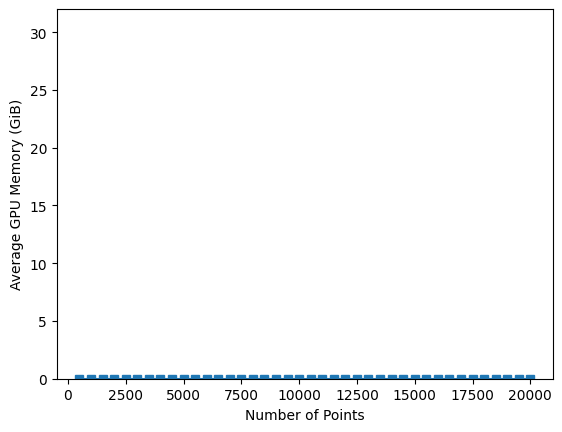

In [10]:
fig, ax = plt.subplots()
ax.plot(points_train, np.mean(mem_used, axis=1), marker='s')
ax.set_ylim([0, 32])
ax.set_xlabel("Number of Points")
ax.set_ylabel("Average GPU Memory (GiB)")
#fig.savefig(result_dir+'gpu_mem.png')

# Time to Train

total run time:  355.76275396347046  s


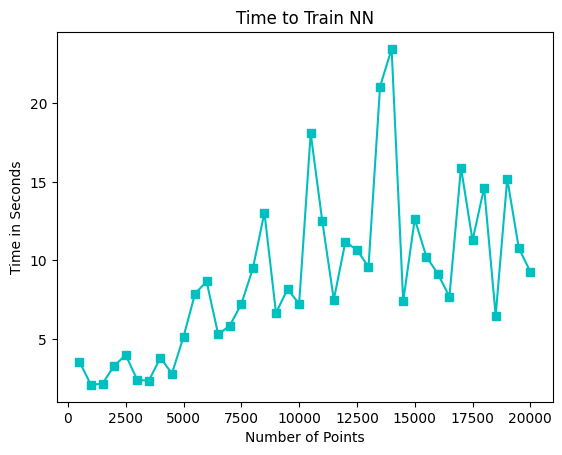

In [11]:
print('total run time: ', sum(time_list), ' s')
fig, ax = plt.subplots()
ax.set_title("Time to Train {}".format(mod_type.upper()))
ax.set_xlabel("Number of Points")
ax.set_ylabel("Time in Seconds")
ax.plot(points_train, time_list, marker='s', c='c', label='Time')
#fig.savefig(result_dir+'time.png')

# Mean Squared Error

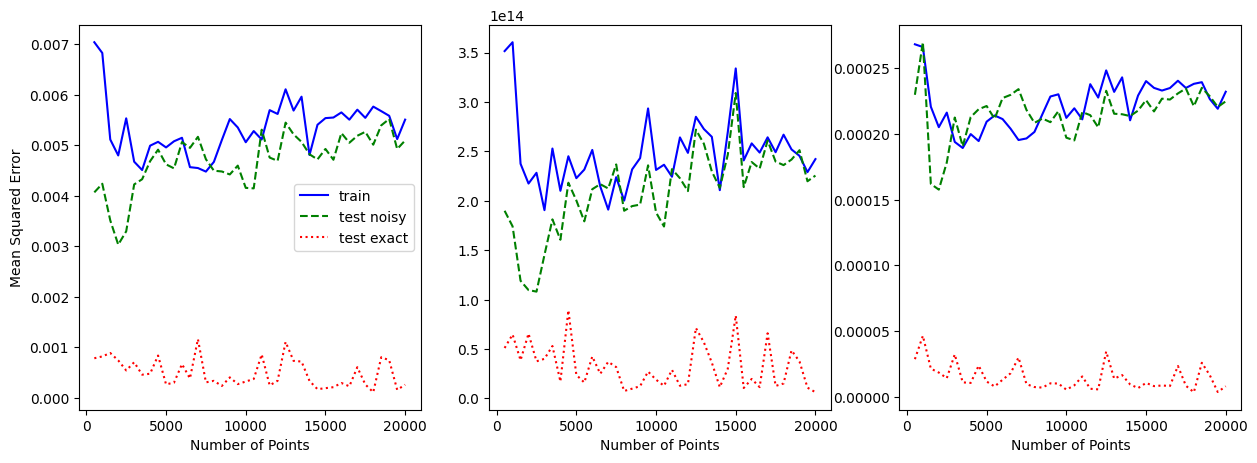

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for j in range(num_outputs):
    ax[j].plot(points_train, train_mse[:, j], c='b', label='train')
    ax[j].plot(points_train, test_mse_noisy[:, j], c='g', label='test noisy', linestyle='dashed')
    ax[j].plot(points_train, test_mse_exact[:, j], c='r', label='test exact', linestyle='dotted')
    ax[j].set_xlabel("Number of Points")
ax[0].set_ylabel("Mean Squared Error")
ax[0].legend(loc='center right')

# Mean Absolute Percentage Error

total run time:  355.76275396347046  s


Text(0, 0.5, 'Mean Absolute Percentage Error')

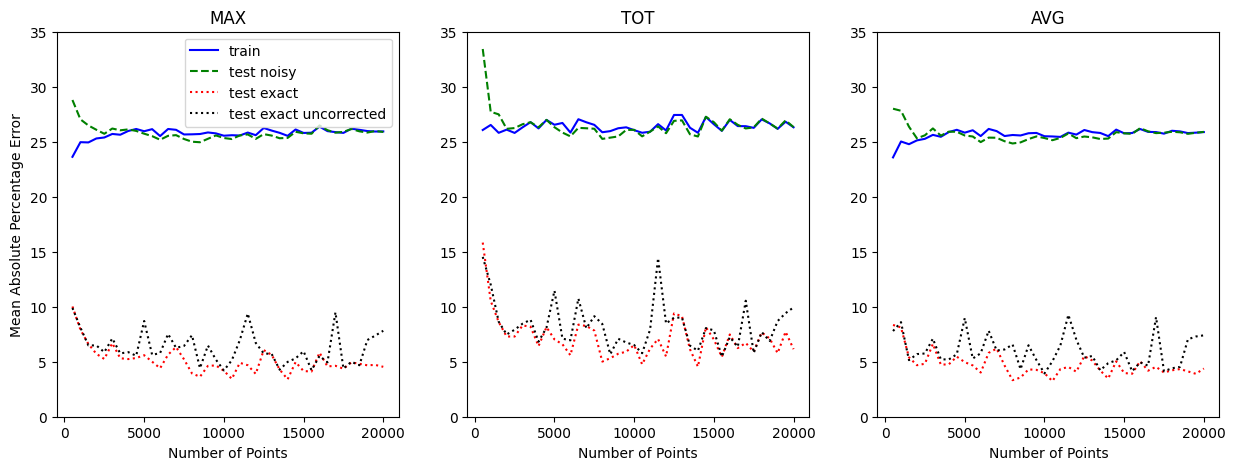

In [13]:
print('total run time: ', sum(time_list), ' s')
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for j in range(num_outputs):
    ax[j].plot(points_train, train_mape[:, j]*100, c='b', label='train')
    ax[j].plot(points_train, test_mape_noisy[:, j]*100, c='g', label='test noisy', linestyle='dashed')
    ax[j].plot(points_train, test_mape_exact[:, j]*100, c='r', label='test exact', linestyle='dotted')
    ax[j].plot(points_train, test_mape_exact_uncorrected[:, j]*100, c='k', label='test exact uncorrected', linestyle='dotted')
    ax[j].set_xlabel("Number of Points")
    ax[j].set_ylim(0, noise+5)
    ax[j].set_title(outs[j].upper())
ax[0].legend(loc='upper right')
ax[0].set_ylabel("Mean Absolute Percentage Error")

# Store Metrics to CSV File

In [14]:
columns = ['train_points', 'gpu_memory', 'time', 
            'train_mse_max', 'train_mse_tot', 'train_mse_avg',
            'test_mse_noisy_max', 'test_mse_noisy_tot', 'test_mse_noisy_avg',
            'test_mse_exact_max', 'test_mse_exact_tot', 'test_mse_exact_avg',
            'train_mape_max', 'train_mape_tot', 'train_mape_avg',
            'test_mape_noisy_max', 'test_mape_noisy_tot', 'test_mape_noisy_avg',
            'test_mape_exact_max', 'test_mape_exact_tot', 'test_mape_exact_avg',
            'test_mape_exact_uncorrected_max', 'test_mape_exact_uncorrected_tot', 'test_mape_exact_uncorrected_avg']
data = [points_train, np.mean(mem_used, axis=1), time_list,
        train_mse[:, 0], train_mse[:, 1], train_mse[:, 2],
        test_mse_noisy[:, 0], test_mse_noisy[:, 1], test_mse_noisy[:, 2],
        test_mse_exact[:, 0], test_mse_exact[:, 1], test_mse_exact[:, 2],
        train_mape[:, 0], train_mape[:, 1], train_mape[:, 2],
        test_mape_noisy[:, 0], test_mape_noisy[:, 1], test_mape_noisy[:, 2],
        test_mape_exact[:, 0], test_mape_exact[:, 1], test_mape_exact[:, 2],
        test_mape_exact_uncorrected[:, 0], test_mape_exact_uncorrected[:, 1], test_mape_exact_uncorrected[:, 2]]
output_df = pd.DataFrame(dict(zip(columns, data)))
display(output_df)

,train_points,gpu_memory,time,train_mse_max,train_mse_tot,train_mse_avg,test_mse_noisy_max,test_mse_noisy_tot,test_mse_noisy_avg,test_mse_exact_max,...,train_mape_avg,test_mape_noisy_max,test_mape_noisy_tot,test_mape_noisy_avg,test_mape_exact_max,test_mape_exact_tot,test_mape_exact_avg,test_mape_exact_uncorrected_max,test_mape_exact_uncorrected_tot,test_mape_exact_uncorrected_avg
0,500,0.0,3.558129,0.007036,3.514377e+14,0.000268,0.004067,1.898966e+14,0.000230,0.000785,...,0.235749,0.287920,0.334293,0.280002,0.100210,0.158295,0.083424,0.098886,0.145309,0.077907
1,1000,0.0,2.078470,0.006823,3.604171e+14,0.000266,0.004237,1.741476e+14,0.000270,0.000821,...,0.250206,0.270355,0.277179,0.278137,0.079193,0.105296,0.081180,0.081019,0.120074,0.085977
2,1500,0.0,2.166113,0.005112,2.374419e+14,0.000221,0.003512,1.190848e+14,0.000162,0.000889,...,0.247743,0.264794,0.274887,0.263673,0.066137,0.086115,0.054021,0.064851,0.086403,0.051444
3,2000,0.0,3.293721,0.004797,2.174420e+14,0.000205,0.003032,1.096680e+14,0.000158,0.000743,...,0.251219,0.260860,0.261723,0.253059,0.057193,0.072923,0.046831,0.064792,0.074777,0.056938
4,2500,0.0,3.979069,0.005531,2.283090e+14,0.000216,0.003296,1.081073e+14,0.000178,0.000544,...,0.252648,0.257227,0.262413,0.255844,0.052478,0.072895,0.048156,0.058709,0.079065,0.057471
5,3000,0.0,2.399894,0.004673,1.905110e+14,0.000194,0.004223,1.452367e+14,0.000213,0.000706,...,0.256229,0.261994,0.265910,0.262084,0.066860,0.082993,0.066206,0.071167,0.084611,0.070982
6,3500,0.0,2.341593,0.004508,2.528543e+14,0.000189,0.004326,1.811994e+14,0.000191,0.000460,...,0.254485,0.260385,0.267708,0.255552,0.053161,0.081812,0.047342,0.057547,0.088169,0.052184
7,4000,0.0,3.811717,0.004990,2.100979e+14,0.000200,0.004683,1.605920e+14,0.000213,0.000479,...,0.258776,0.261202,0.263090,0.259146,0.052398,0.064245,0.047626,0.058721,0.068236,0.052035
8,4500,0.0,2.800589,0.005066,2.450478e+14,0.000195,0.004911,2.182781e+14,0.000219,0.000839,...,0.260834,0.259815,0.269847,0.259038,0.053374,0.081452,0.054598,0.055418,0.080974,0.056784
9,5000,0.0,5.137125,0.004956,2.228783e+14,0.000209,0.004621,2.003609e+14,0.000221,0.000268,...,0.258241,0.257294,0.263185,0.255665,0.055918,0.070280,0.049588,0.087036,0.114614,0.089658


In [15]:
output_df.to_csv(result_dir + 'metrics.csv', index=False)